In [19]:
import os
import shutil
import glob
import yaml
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from ultralytics import YOLO
import torch
from PIL import Image

In [13]:
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
print(f"PyTorch Version: {torch.__version__}")


GPU Available: True
GPU Device: NVIDIA GeForce RTX 3060
PyTorch Version: 2.5.1


In [3]:
source_base_dir = '.'  # Assumes 'Train' and 'Val' are in the current directory
dest_base_dir = 'dataset' # Name of the new folder for the reorganized data
classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
# --- End Configuration ---

# Create the necessary directories
for split in ['train', 'val']:
    os.makedirs(os.path.join(dest_base_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dest_base_dir, split, 'labels'), exist_ok=True)

def reorganize_files(split):
    """Reorganizes files for a given split (train/val)."""
    source_dir_name = 'Train' if split == 'train' else 'Val'
    source_path = os.path.join(source_base_dir, source_dir_name)
    
    if not os.path.exists(source_path):
        print(f"Warning: Source directory not found at {source_path}")
        return

    print(f"Processing '{source_path}' directory...")
    
    for class_name in classes:
        class_path = os.path.join(source_path, class_name)
        
        # Copy images
        image_files = glob.glob(os.path.join(class_path, 'images', '*.jpg'))
        for src_file in image_files:
            shutil.copy(src_file, os.path.join(dest_base_dir, split, 'images'))
            
        # Copy labels
        label_files = glob.glob(os.path.join(class_path, 'labels', '*.txt'))
        for src_file in label_files:
            shutil.copy(src_file, os.path.join(dest_base_dir, split, 'labels'))

    print(f"Finished reorganizing for {split} split.")

# Run the reorganization
reorganize_files('train')
reorganize_files('val')

print("\n✅ Dataset reorganization complete!")

Processing '.\Train' directory...
Finished reorganizing for train split.
Processing '.\Val' directory...
Finished reorganizing for val split.

✅ Dataset reorganization complete!


In [5]:
data_yaml = {
    'path': os.path.abspath(dest_base_dir),  # Absolute path to the dataset directory
    'train': 'train/images',  # Path to training images relative to 'path'
    'val': 'val/images',      # Path to validation images relative to 'path'
    'names': {
        0: 'Glioma',
        1: 'Meningioma',
        2: 'No Tumor',
        3: 'Pituitary'
    }
}

# Write the data.yaml file
yaml_path = os.path.join(dest_base_dir, 'brain_tumor.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print(f"✅ YAML file created at: {yaml_path}")
print("\nYAML Content:\n")
with open(yaml_path, 'r') as f:
    print(f.read())

✅ YAML file created at: dataset\brain_tumor.yaml

YAML Content:

path: c:\Users\PC\Documents\A\Pre-sem 5\Object Detection Brain Tumor\dataset
train: train/images
val: val/images
names:
  0: Glioma
  1: Meningioma
  2: No Tumor
  3: Pituitary



In [7]:
DATASET_DIR = 'dataset' # The folder you created earlier
CLASS_NAMES = {0: 'Glioma', 1: 'Meningioma', 2: 'No Tumor', 3: 'Pituitary'}

def get_image_paths(directory):
    """Gets all image paths from a directory."""
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Collect data from the training set
train_image_paths = get_image_paths(os.path.join(DATASET_DIR, 'train', 'images'))

data = []
for img_path in tqdm(train_image_paths, desc="Analyzing Training Data"):
    # Get image dimensions
    image = cv2.imread(img_path)
    h, w, _ = image.shape
    
    # Get label path
    label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                class_id = int(parts[0])
                # YOLO format: class x_center y_center width height
                box_w = float(parts[3]) * w
                box_h = float(parts[4]) * h
                
                data.append([
                    os.path.basename(img_path),
                    w, h, CLASS_NAMES[class_id],
                    box_w, box_h, box_w * box_h
                ])

# Create a DataFrame for easy analysis
df = pd.DataFrame(data, columns=['filename', 'width', 'height', 'class_name', 'box_w', 'box_h', 'box_area'])

print(f"\nFound {df.shape[0]} annotations across {df['filename'].nunique()} images.")

Analyzing Training Data: 100%|██████████| 4737/4737 [01:00<00:00, 78.49it/s]


Found 5317 annotations across 4737 images.


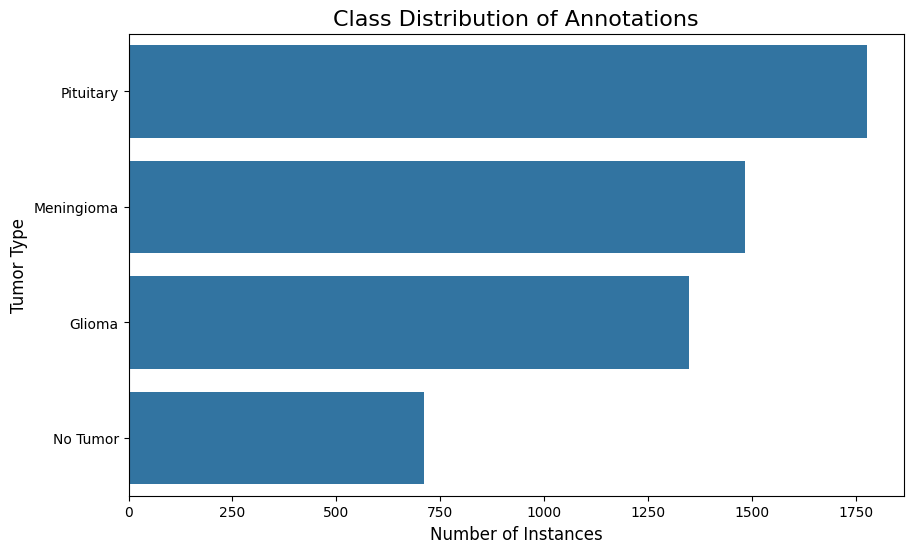

In [8]:
# --- 1. Class Distribution ---
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='class_name', order=df['class_name'].value_counts().index)
plt.title('Class Distribution of Annotations', fontsize=16)
plt.xlabel('Number of Instances', fontsize=12)
plt.ylabel('Tumor Type', fontsize=12)
plt.show()

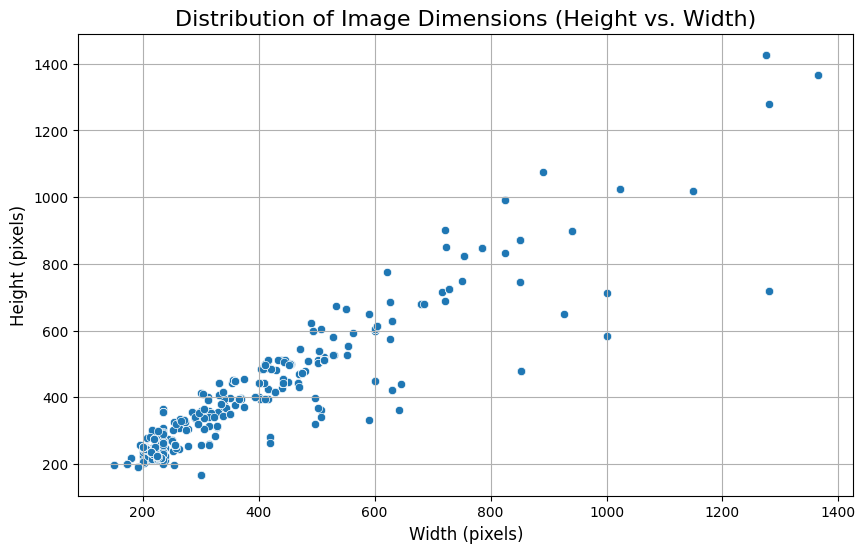

In [9]:
# --- 2. Image Dimensions ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.drop_duplicates(subset=['filename']), x='width', y='height')
plt.title('Distribution of Image Dimensions (Height vs. Width)', fontsize=16)
plt.xlabel('Width (pixels)', fontsize=12)
plt.ylabel('Height (pixels)', fontsize=12)
plt.grid(True)
plt.show()

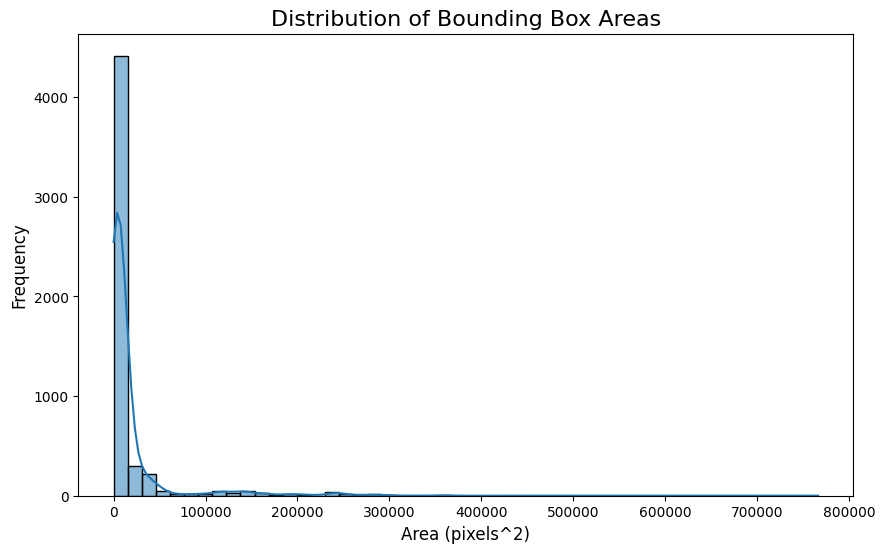

In [10]:
# --- 3. Bounding Box Area Distribution ---
plt.figure(figsize=(10, 6))
sns.histplot(df['box_area'], bins=50, kde=True)
plt.title('Distribution of Bounding Box Areas', fontsize=16)
plt.xlabel('Area (pixels^2)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


Displaying random samples with annotations...


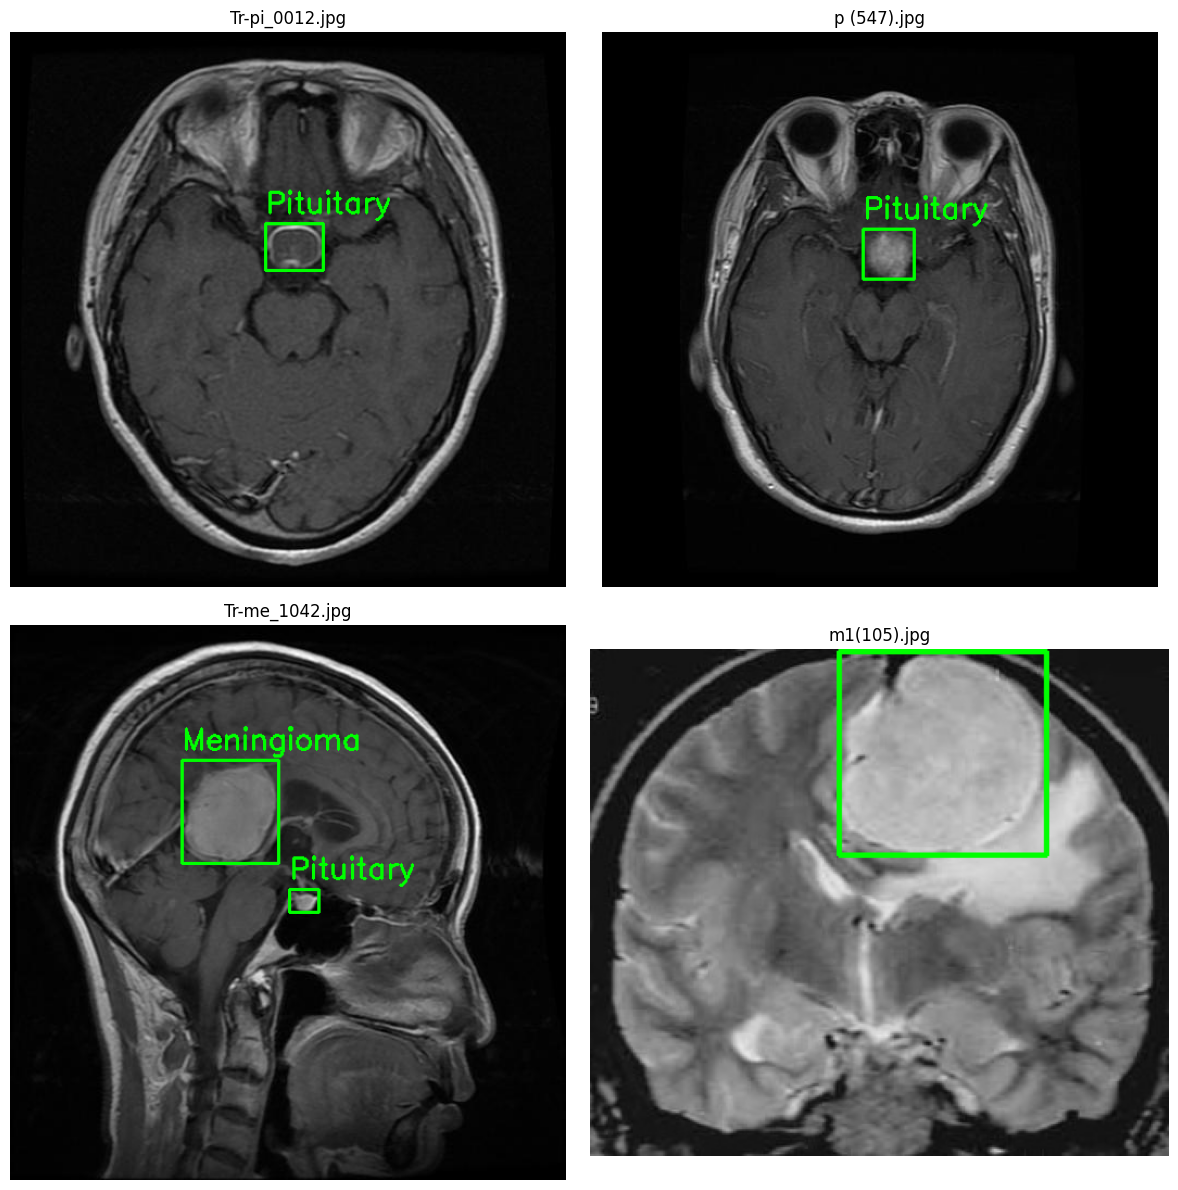

In [11]:
# --- 4. Visualize Sample Images with Bounding Boxes ---
print("\nDisplaying random samples with annotations...")
sample_images = random.sample(train_image_paths, k=min(4, len(train_image_paths)))

plt.figure(figsize=(12, 12))
for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Matplotlib uses RGB
    h, w, _ = img.shape
    
    label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, box_w, box_h = map(float, parts[1:])
                
                # Convert YOLO format to pixel coordinates
                x1 = int((x_center - box_w / 2) * w)
                y1 = int((y_center - box_h / 2) * h)
                x2 = int((x_center + box_w / 2) * w)
                y2 = int((y_center + box_h / 2) * h)
                
                # Draw rectangle and label
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, CLASS_NAMES[class_id], (x1, y1 - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Initialize YOLOv11 model
model = YOLO('yolo11n.pt')  # You can use yolo11s.pt, yolo11m.pt, yolo11l.pt, yolo11x.pt for larger models

print("Model loaded successfully!")
print(f"Model summary:")
print(model.model)

100%|██████████| 5.35M/5.35M [00:00<00:00, 11.1MB/s]

Model loaded successfully!
Model summary:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
   

In [16]:
training_params = {
    'data': yaml_path,           # Path to your YAML file
    'epochs': 100,               # Number of training epochs
    'imgsz': 640,               # Image size
    'batch': 8,                # Batch size (adjust based on GPU memory)
    'patience': 15,             # Early stopping patience
    'save': True,               # Save model checkpoints
    'save_period': 10,          # Save checkpoint every N epochs
    'cache': False,             # Cache images for faster training
    'device': 0,                # GPU device (0 for first GPU, 'cpu' for CPU)
    'workers': 4,               # Number of worker threads
    'project': 'runs/detect',   # Project folder
    'name': 'brain_tumor_yolo11', # Experiment name
    'exist_ok': True,           # Allow overwriting existing project
    'pretrained': True,         # Use pretrained weights
    'optimizer': 'AdamW',        # Optimizer (auto, SGD, Adam, AdamW, NAdam, RAdam, RMSProp)
    'verbose': True,            # Verbose output
    'seed': 42,                # Random seed for reproducibility
    'deterministic': True,      # Make training deterministic
    'single_cls': False,        # Single class training
    'rect': False,              # Rectangular training
    'cos_lr': False,            # Cosine learning rate scheduler
    'close_mosaic': 10,         # Disable mosaic augmentation for last N epochs
    'resume': False,            # Resume training from last checkpoint
    'amp': True,                # Automatic Mixed Precision training
}

In [17]:
print("Starting training...")

results = model.train(**training_params)

print("Training completed!")

Starting training...
Ultralytics 8.3.170  Python-3.9.23 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset\brain_tumor.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=brain_tumor_yolo11, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=15, perspective=0.0, 

100%|██████████| 755k/755k [00:00<00:00, 8.52MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    431452  ultralytics.nn.modules.head.Detect           [4, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,620 parameters, 2,590,604 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 71.429.6 MB/s, size: 24.8 KB)


train: Scanning C:\Users\PC\Documents\A\Pre-sem 5\Object Detection Brain Tumor\dataset\train\labels... 4737 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4737/4737 [00:02<00:00, 2124.30it/s]


train: New cache created: C:\Users\PC\Documents\A\Pre-sem 5\Object Detection Brain Tumor\dataset\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 2.80.7 MB/s, size: 24.5 KB)


val: Scanning C:\Users\PC\Documents\A\Pre-sem 5\Object Detection Brain Tumor\dataset\val\labels... 510 images, 3 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:01<00:00, 418.02it/s]

val: New cache created: C:\Users\PC\Documents\A\Pre-sem 5\Object Detection Brain Tumor\dataset\val\labels.cache


Plotting labels to runs\detect\brain_tumor_yolo11\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\brain_tumor_yolo11
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.21G      1.426       2.05      1.568          1        640: 100%|██████████| 593/593 [01:03<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00, 10.18it/s]

                   all        512        554      0.685      0.331      0.406      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.54G      1.392      1.658      1.534          3        640: 100%|██████████| 593/593 [00:55<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.28it/s]

                   all        512        554      0.553       0.35      0.306      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.54G      1.295      1.465      1.453          0        640: 100%|██████████| 593/593 [00:53<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.61it/s]


                   all        512        554      0.706       0.69      0.732      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.54G      1.237      1.347      1.425          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.51it/s]

                   all        512        554       0.77      0.625      0.739      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.54G      1.217      1.262      1.389          1        640: 100%|██████████| 593/593 [00:54<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.96it/s]


                   all        512        554      0.696      0.712       0.75      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.54G      1.159      1.161      1.356          1        640: 100%|██████████| 593/593 [00:57<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.38it/s]

                   all        512        554      0.628      0.693      0.681      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.54G      1.145      1.119      1.339          1        640: 100%|██████████| 593/593 [00:56<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.07it/s]

                   all        512        554      0.818      0.722      0.806      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.54G      1.119       1.07      1.316          4        640: 100%|██████████| 593/593 [00:56<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.91it/s]


                   all        512        554      0.806      0.801      0.879      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.54G      1.111      1.063        1.3          6        640: 100%|██████████| 593/593 [00:54<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.33it/s]

                   all        512        554      0.844      0.765      0.849      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.54G       1.08      1.028      1.294          2        640: 100%|██████████| 593/593 [00:53<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.67it/s]

                   all        512        554      0.689      0.601      0.695      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.54G      1.061     0.9681      1.276          1        640: 100%|██████████| 593/593 [00:53<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.01it/s]

                   all        512        554      0.812      0.789      0.878      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.54G      1.043     0.9778      1.268          1        640: 100%|██████████| 593/593 [00:55<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.51it/s]

                   all        512        554      0.702      0.701      0.733      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.54G      1.037     0.9529      1.261          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.12it/s]

                   all        512        554      0.826      0.798      0.869      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.54G      1.031     0.9163      1.258          2        640: 100%|██████████| 593/593 [00:54<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.53it/s]


                   all        512        554      0.802      0.814       0.89      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.54G      1.028     0.9009      1.254          2        640: 100%|██████████| 593/593 [00:55<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.81it/s]

                   all        512        554      0.885      0.822      0.903      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.54G      1.032      0.885      1.245          1        640: 100%|██████████| 593/593 [00:54<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00, 10.27it/s]

                   all        512        554      0.875      0.861      0.912      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.54G      1.006     0.8774      1.233          1        640: 100%|██████████| 593/593 [00:54<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.94it/s]

                   all        512        554      0.918      0.831      0.909      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.54G     0.9985     0.8611      1.234          2        640: 100%|██████████| 593/593 [00:55<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.86it/s]

                   all        512        554       0.86      0.834        0.9      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.54G     0.9873     0.8474      1.222          3        640: 100%|██████████| 593/593 [00:55<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.25it/s]


                   all        512        554      0.864      0.828      0.888      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.54G     0.9795     0.8312      1.217          1        640: 100%|██████████| 593/593 [00:55<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.05it/s]

                   all        512        554      0.894      0.832      0.908      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.54G     0.9695     0.8261      1.205          3        640: 100%|██████████| 593/593 [00:55<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.35it/s]

                   all        512        554      0.816      0.865      0.912      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.54G     0.9867     0.8188      1.219          4        640: 100%|██████████| 593/593 [00:56<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.71it/s]

                   all        512        554      0.912       0.85      0.918      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.54G     0.9544      0.798      1.203          1        640: 100%|██████████| 593/593 [00:56<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.24it/s]

                   all        512        554      0.844      0.866      0.921      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.54G     0.9555     0.8073      1.201          1        640: 100%|██████████| 593/593 [00:55<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.82it/s]

                   all        512        554      0.867      0.853       0.92      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.54G     0.9481     0.7779        1.2          1        640: 100%|██████████| 593/593 [00:56<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00, 10.25it/s]

                   all        512        554      0.901      0.851      0.925      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.54G     0.9386     0.7652      1.186          1        640: 100%|██████████| 593/593 [00:59<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.18it/s]


                   all        512        554      0.922      0.863      0.929        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.54G     0.9387     0.7462      1.184          1        640: 100%|██████████| 593/593 [00:59<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


                   all        512        554      0.882      0.864      0.925      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.54G     0.9275     0.7524       1.18          2        640: 100%|██████████| 593/593 [00:57<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.78it/s]

                   all        512        554      0.906      0.873       0.94      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.54G     0.9374     0.7358      1.186          2        640: 100%|██████████| 593/593 [00:58<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.96it/s]

                   all        512        554      0.753      0.732      0.819      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.54G     0.9205     0.7318      1.177          2        640: 100%|██████████| 593/593 [00:56<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.29it/s]

                   all        512        554      0.899      0.884      0.932      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.54G     0.9246       0.74      1.173          0        640: 100%|██████████| 593/593 [00:55<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.22it/s]

                   all        512        554      0.862      0.868      0.921      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.54G     0.9159     0.7243      1.167          3        640: 100%|██████████| 593/593 [00:55<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.97it/s]

                   all        512        554      0.934      0.867      0.939      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.54G      0.905     0.7186      1.169          1        640: 100%|██████████| 593/593 [00:57<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.20it/s]

                   all        512        554      0.925      0.883      0.939      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.54G     0.9101     0.7186      1.169          1        640: 100%|██████████| 593/593 [00:57<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00, 10.39it/s]

                   all        512        554      0.869      0.892      0.927      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.54G     0.8982     0.6826      1.162          2        640: 100%|██████████| 593/593 [00:56<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.21it/s]

                   all        512        554      0.933      0.874      0.947      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.54G     0.8955     0.7055       1.16          2        640: 100%|██████████| 593/593 [00:58<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00, 10.45it/s]

                   all        512        554      0.915      0.848      0.927      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.54G     0.8972      0.695      1.151          2        640: 100%|██████████| 593/593 [00:54<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.18it/s]

                   all        512        554      0.926      0.887      0.943      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.54G     0.8919     0.6824      1.158          4        640: 100%|██████████| 593/593 [00:57<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00, 10.50it/s]

                   all        512        554       0.92      0.908      0.949      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.54G     0.9026     0.6807      1.161          2        640: 100%|██████████| 593/593 [00:54<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.52it/s]

                   all        512        554      0.906      0.894      0.941      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.54G     0.8941     0.6815      1.157          1        640: 100%|██████████| 593/593 [00:54<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.89it/s]

                   all        512        554      0.908      0.855      0.926      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.54G     0.8878     0.6639      1.155          3        640: 100%|██████████| 593/593 [00:54<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.72it/s]

                   all        512        554      0.925      0.893       0.94       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.54G      0.878     0.6529      1.151          1        640: 100%|██████████| 593/593 [00:55<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.29it/s]

                   all        512        554      0.916      0.895      0.939      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.54G     0.8767      0.661      1.146          1        640: 100%|██████████| 593/593 [00:55<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.64it/s]

                   all        512        554      0.924       0.88      0.938      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.54G      0.863     0.6343      1.132          2        640: 100%|██████████| 593/593 [00:54<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.47it/s]

                   all        512        554      0.895      0.915      0.942      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.54G     0.8688      0.657       1.14          2        640: 100%|██████████| 593/593 [00:54<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.70it/s]

                   all        512        554      0.927       0.91      0.944      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.54G     0.8459     0.6239      1.122          0        640: 100%|██████████| 593/593 [00:53<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.48it/s]

                   all        512        554      0.928      0.894      0.943      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.54G     0.8603     0.6393      1.137          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.50it/s]

                   all        512        554      0.927      0.894      0.949      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.54G     0.8551     0.6304      1.135          3        640: 100%|██████████| 593/593 [00:55<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.64it/s]

                   all        512        554      0.926       0.89      0.945      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.54G     0.8657     0.6281      1.131          2        640: 100%|██████████| 593/593 [00:54<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.88it/s]

                   all        512        554       0.94      0.886      0.946      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.54G     0.8523     0.6159      1.128          3        640: 100%|██████████| 593/593 [00:55<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.14it/s]

                   all        512        554       0.93      0.908       0.95      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.54G     0.8484     0.6103      1.131          2        640: 100%|██████████| 593/593 [00:55<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.16it/s]

                   all        512        554      0.917      0.922       0.95       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.54G     0.8436      0.598      1.123          3        640: 100%|██████████| 593/593 [00:55<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.64it/s]

                   all        512        554      0.931       0.91      0.957      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.54G     0.8428     0.6192      1.129          1        640: 100%|██████████| 593/593 [00:57<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.85it/s]

                   all        512        554      0.935      0.908      0.957       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.54G     0.8317     0.5964      1.117          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.38it/s]

                   all        512        554      0.932       0.89      0.949      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.54G     0.8337     0.5894      1.121          1        640: 100%|██████████| 593/593 [00:52<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.09it/s]

                   all        512        554      0.944      0.907      0.955      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.54G     0.8306     0.5876      1.119          2        640: 100%|██████████| 593/593 [00:51<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.53it/s]

                   all        512        554      0.944      0.894       0.95      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.54G     0.8263     0.5772      1.113          3        640: 100%|██████████| 593/593 [00:51<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.01it/s]

                   all        512        554      0.944      0.914      0.959      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.54G      0.838     0.5848      1.117          4        640: 100%|██████████| 593/593 [00:50<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.27it/s]

                   all        512        554      0.937      0.921      0.957      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.54G     0.8201     0.5725      1.115          1        640: 100%|██████████| 593/593 [00:51<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.19it/s]

                   all        512        554      0.929       0.92      0.955      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.54G     0.8204     0.5691       1.11          3        640: 100%|██████████| 593/593 [00:52<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.55it/s]

                   all        512        554      0.942      0.916      0.959      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.54G     0.8324     0.5781      1.121          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.46it/s]

                   all        512        554      0.944      0.905      0.959      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.54G     0.8107     0.5613      1.107          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.61it/s]

                   all        512        554      0.944      0.904      0.958      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.54G     0.8101     0.5594      1.101          0        640: 100%|██████████| 593/593 [00:53<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.61it/s]

                   all        512        554      0.956      0.905       0.96      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.54G     0.8129     0.5683      1.102          3        640: 100%|██████████| 593/593 [00:53<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.49it/s]

                   all        512        554      0.916      0.919      0.959      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.54G     0.8089     0.5627      1.099          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.48it/s]

                   all        512        554      0.925       0.94      0.962      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.54G     0.8065     0.5563      1.107          0        640: 100%|██████████| 593/593 [00:53<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.59it/s]

                   all        512        554      0.935      0.917      0.957      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.54G     0.8069     0.5469      1.101          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.62it/s]

                   all        512        554      0.925      0.938      0.957      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.54G     0.7936     0.5358      1.099          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.46it/s]

                   all        512        554       0.91      0.946      0.958      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.54G       0.79     0.5306      1.095          0        640: 100%|██████████| 593/593 [00:53<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.35it/s]

                   all        512        554      0.926       0.93      0.954      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.54G     0.8023     0.5367      1.101          2        640: 100%|██████████| 593/593 [00:53<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.79it/s]

                   all        512        554      0.952      0.903      0.961      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.54G     0.7754     0.5249      1.082          2        640: 100%|██████████| 593/593 [00:51<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.96it/s]

                   all        512        554       0.93      0.931       0.96      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.54G     0.7895     0.5252       1.09          1        640: 100%|██████████| 593/593 [00:51<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.06it/s]

                   all        512        554      0.941      0.932      0.958      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.54G     0.8007     0.5266      1.102          1        640: 100%|██████████| 593/593 [00:51<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.35it/s]


                   all        512        554       0.94       0.93      0.963      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.54G     0.7861     0.5148      1.094          1        640: 100%|██████████| 593/593 [00:52<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.69it/s]

                   all        512        554      0.941      0.919      0.962      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.54G     0.7767     0.5164      1.087          1        640: 100%|██████████| 593/593 [00:52<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.13it/s]


                   all        512        554      0.934      0.932      0.958      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.54G     0.7769     0.5161      1.087          5        640: 100%|██████████| 593/593 [00:54<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.21it/s]

                   all        512        554      0.946      0.915      0.963      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.54G     0.7749     0.5169      1.089          2        640: 100%|██████████| 593/593 [00:53<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.19it/s]

                   all        512        554      0.922      0.934      0.963      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.54G     0.7796     0.5171      1.084          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.57it/s]

                   all        512        554      0.951      0.913      0.961      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.54G      0.781     0.5148      1.088          3        640: 100%|██████████| 593/593 [00:54<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.31it/s]

                   all        512        554      0.919       0.94      0.963      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.54G     0.7622     0.5009       1.08          2        640: 100%|██████████| 593/593 [00:55<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.74it/s]

                   all        512        554      0.941      0.926       0.96      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.54G     0.7843     0.4963      1.091          1        640: 100%|██████████| 593/593 [00:51<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.22it/s]

                   all        512        554      0.958      0.915      0.964      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.54G     0.7666     0.5017       1.08          1        640: 100%|██████████| 593/593 [00:51<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.45it/s]

                   all        512        554      0.952      0.911      0.965      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.54G     0.7519     0.4904      1.067          2        640: 100%|██████████| 593/593 [00:51<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.30it/s]

                   all        512        554      0.931       0.94      0.966      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.54G      0.765     0.4957      1.081          1        640: 100%|██████████| 593/593 [00:51<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.53it/s]

                   all        512        554      0.929      0.938      0.964      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.54G      0.751     0.4822      1.074          1        640: 100%|██████████| 593/593 [00:51<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.38it/s]

                   all        512        554      0.935       0.93      0.965      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.54G     0.7601     0.4785      1.077          1        640: 100%|██████████| 593/593 [00:54<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.61it/s]

                   all        512        554      0.959      0.911      0.965      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.54G     0.7511     0.4746      1.065          1        640: 100%|██████████| 593/593 [00:54<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.53it/s]

                   all        512        554      0.935      0.929      0.962      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.54G     0.7583     0.4781      1.075          4        640: 100%|██████████| 593/593 [00:54<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.60it/s]

                   all        512        554       0.94      0.922      0.962       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.54G     0.7534     0.4739      1.068          4        640: 100%|██████████| 593/593 [00:54<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.67it/s]

                   all        512        554      0.937       0.93      0.961       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.54G     0.7365     0.4625      1.062          1        640: 100%|██████████| 593/593 [00:54<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.70it/s]

                   all        512        554      0.964      0.912      0.961      0.781


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.54G     0.7131     0.4324      1.046          1        640: 100%|██████████| 593/593 [00:53<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.60it/s]


                   all        512        554      0.957      0.912      0.959      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.54G     0.7024     0.4167      1.038          1        640: 100%|██████████| 593/593 [00:52<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.72it/s]

                   all        512        554       0.96      0.917      0.959      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.54G     0.6906     0.4083      1.032          1        640: 100%|██████████| 593/593 [00:52<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.55it/s]

                   all        512        554      0.949      0.917      0.961      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.54G     0.6885     0.4132      1.033          1        640: 100%|██████████| 593/593 [00:52<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.68it/s]

                   all        512        554      0.958      0.915      0.962      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.54G     0.6797     0.4017      1.023          1        640: 100%|██████████| 593/593 [00:52<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.23it/s]

                   all        512        554      0.958       0.92      0.962      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.54G     0.6795     0.3954      1.023          1        640: 100%|██████████| 593/593 [23:22<00:00,  2.36s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.74it/s]


                   all        512        554      0.958      0.916       0.96      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.54G     0.6791     0.3914      1.024          1        640: 100%|██████████| 593/593 [00:54<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.36it/s]

                   all        512        554       0.96      0.912      0.961      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.54G     0.6781     0.3894      1.022          2        640: 100%|██████████| 593/593 [00:54<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 12.02it/s]

                   all        512        554      0.954       0.92      0.961      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.54G     0.6771     0.3906      1.022          1        640: 100%|██████████| 593/593 [00:52<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.65it/s]

                   all        512        554      0.959      0.914      0.961      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.54G     0.6679     0.3819      1.016          1        640: 100%|██████████| 593/593 [00:52<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 11.93it/s]

                   all        512        554      0.959      0.916      0.962      0.782



100 epochs completed in 1.978 hours.
Optimizer stripped from runs\detect\brain_tumor_yolo11\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\brain_tumor_yolo11\weights\best.pt, 5.5MB

Validating runs\detect\brain_tumor_yolo11\weights\best.pt...
Ultralytics 8.3.170  Python-3.9.23 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


                   all        512        554      0.959      0.914      0.961      0.784
                Glioma        135        153       0.94       0.82      0.929      0.734
            Meningioma        140        142      0.993      0.987      0.992      0.839
              No Tumor         98         98      0.979      0.974      0.978      0.813
             Pituitary        154        161      0.925      0.876      0.944      0.753
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\brain_tumor_yolo11
Training completed!


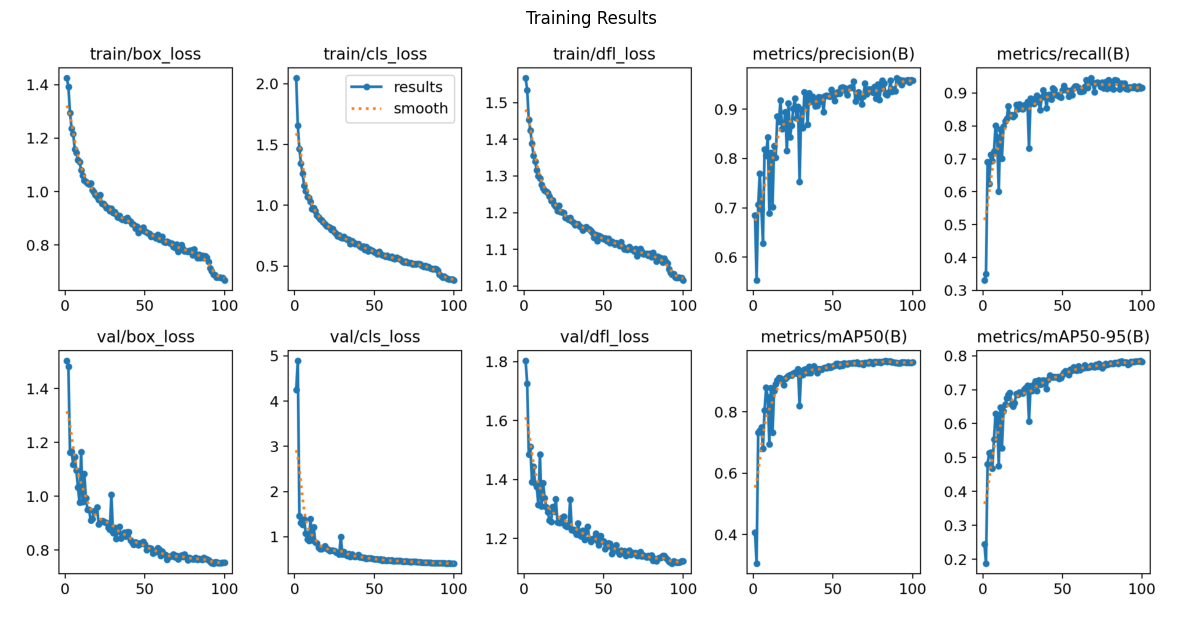

In [20]:
# Plot training results
def plot_training_results():
    """Plot training metrics"""
    results_dir = f"runs/detect/{training_params['name']}"
    
    # Check if results.png exists
    results_img_path = os.path.join(results_dir, "results.png")
    if os.path.exists(results_img_path):
        img = Image.open(results_img_path)
        plt.figure(figsize=(15, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Training Results")
        plt.show()
    else:
        print("Results plot not found.")

# Display training results
plot_training_results()

In [21]:
# Load the best trained model
best_model_path = f"runs/detect/{training_params['name']}/weights/best.pt"
trained_model = YOLO(best_model_path)

print(f"Loading best model from: {best_model_path}")

# Validate the model
validation_results = trained_model.val(data=yaml_path, imgsz=640, batch=16, conf=0.25, iou=0.6)

print("Validation Results:")
print(f"mAP50: {validation_results.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP50-95: {validation_results.results_dict['metrics/mAP50-95(B)']:.4f}")


Loading best model from: runs/detect/brain_tumor_yolo11/weights/best.pt
Ultralytics 8.3.170  Python-3.9.23 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 156.1106.4 MB/s, size: 17.1 KB)


val: Scanning C:\Users\PC\Documents\A\Pre-sem 5\Object Detection Brain Tumor\dataset\val\labels.cache... 510 images, 3 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.30it/s]


                   all        512        554       0.96      0.916      0.953      0.802
                Glioma        135        153      0.935      0.824       0.92      0.764
            Meningioma        140        142      0.993       0.99      0.992      0.857
              No Tumor         98         98      0.979      0.975      0.978      0.823
             Pituitary        154        161      0.932      0.876      0.924      0.762
Speed: 0.6ms preprocess, 3.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\val
Validation Results:
mAP50: 0.9533
mAP50-95: 0.8017



Testing on: gg (10).jpg



image 1/1 c:\Users\PC\Documents\A\Pre-sem 5\Object Detection Brain Tumor\dataset\val\images\gg (10).jpg: 640x640 1 Glioma, 84.4ms
Speed: 5.6ms preprocess, 84.4ms inference, 12.3ms postprocess per image at shape (1, 3, 640, 640)


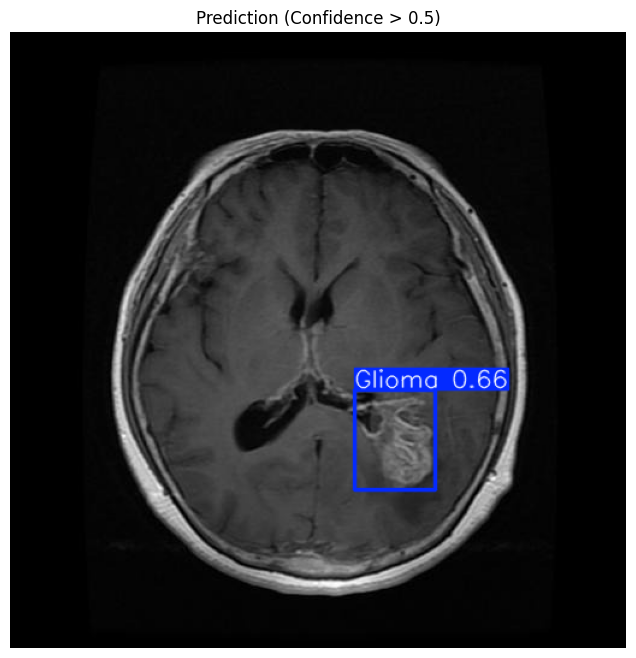

Found 1 detection(s):
  Class: 0, Confidence: 0.661

Testing on: gg (131).jpg

image 1/1 c:\Users\PC\Documents\A\Pre-sem 5\Object Detection Brain Tumor\dataset\val\images\gg (131).jpg: 640x640 4 Gliomas, 67.2ms
Speed: 4.8ms preprocess, 67.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


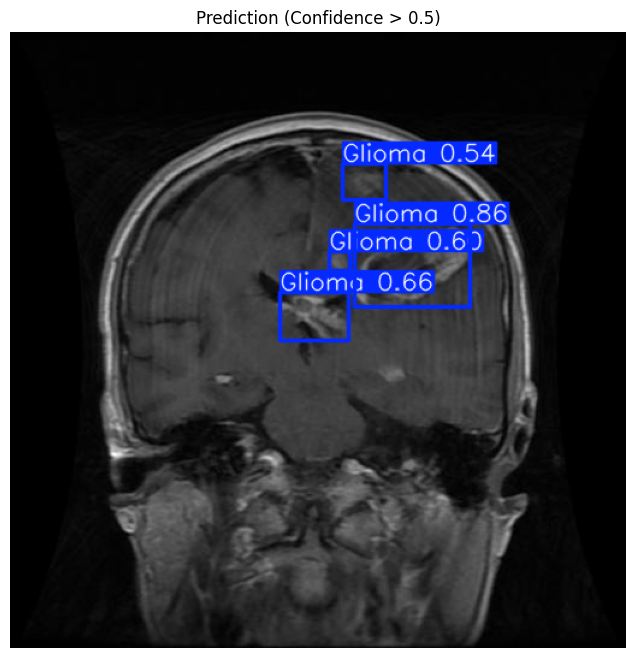

Found 4 detection(s):
  Class: 0, Confidence: 0.862
  Class: 0, Confidence: 0.657
  Class: 0, Confidence: 0.596
  Class: 0, Confidence: 0.545

Testing on: gg (132).jpg

image 1/1 c:\Users\PC\Documents\A\Pre-sem 5\Object Detection Brain Tumor\dataset\val\images\gg (132).jpg: 640x640 3 Gliomas, 89.4ms
Speed: 9.5ms preprocess, 89.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


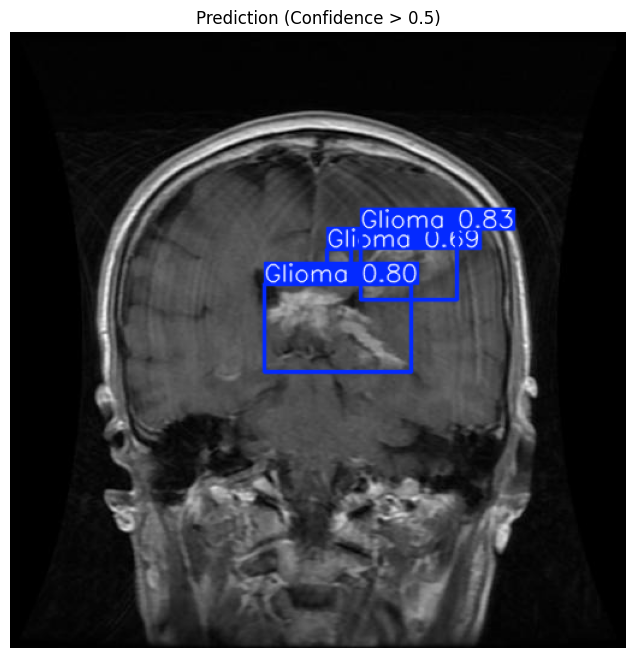

Found 3 detection(s):
  Class: 0, Confidence: 0.830
  Class: 0, Confidence: 0.797
  Class: 0, Confidence: 0.695


In [23]:
val_path = os.path.join("dataset", "val")

def predict_and_visualize(model, image_path, conf_threshold=0.5):
    """Make prediction and visualize results"""
    # Make prediction
    results = model(image_path, conf=conf_threshold)
    
    # Display results
    for r in results:
        im_array = r.plot()  # Plot bounding boxes on image
        im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
        
        plt.figure(figsize=(10, 8))
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Prediction (Confidence > {conf_threshold})")
        plt.show()
        
        # Print detection details
        if len(r.boxes) > 0:
            print(f"Found {len(r.boxes)} detection(s):")
            for box in r.boxes:
                conf = box.conf[0].item()
                cls = int(box.cls[0].item())
                print(f"  Class: {cls}, Confidence: {conf:.3f}")
        else:
            print("No detections found.")

# Test on validation images
val_images_path = os.path.join(val_path, "images")
test_images = os.listdir(val_images_path)[:3]  # Test on first 3 validation images

for img_file in test_images:
    img_path = os.path.join(val_images_path, img_file)
    print(f"\nTesting on: {img_file}")
    predict_and_visualize(trained_model, img_path, conf_threshold=0.5)


In [24]:
print("Exporting model...")

# Export to ONNX (recommended for production)
onnx_path = trained_model.export(format='onnx', imgsz=640)
print(f"Model exported to ONNX: {onnx_path}")

# Export to TensorRT (for NVIDIA GPUs)
try:
    trt_path = trained_model.export(format='engine', imgsz=640)
    print(f"Model exported to TensorRT: {trt_path}")
except Exception as e:
    print(f"TensorRT export failed: {e}")

Exporting model...
Ultralytics 8.3.170  Python-3.9.23 torch-2.5.1 CPU (12th Gen Intel Core(TM) i5-12400F)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs\detect\brain_tumor_yolo11\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ---------------------------------------- 14.5/14.5 MB 11.7 MB/s eta 0:00:00
   --------------------------------------- 226.4/226.4 MB 11.7 MB/s eta 0:00:00
   ---------------------------------------- 6.3/6.3 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:------------- 1/8 [sympy]
      Successfully uninstalled sympy-1.13.1 1/8 [sympy]
   ---------------------------------